In [23]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import scipy
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [3]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

data_mode = 'emuPk'
dir_data = '../data/emuPks'
tag_datagen = '_2param'
tag_errG = f'_boxsize500'
tag_data = '_'+data_mode + tag_datagen + tag_errG


In [4]:
if data_mode == 'emuPk':
    # leave this fixed so we don't mix the sets; then we'll subsample
    frac_train=0.85
    frac_val=0.05
    frac_test=0.1
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15

In [6]:
theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_datagen, tag_errG)

(10000, 2) (10000, 30) (30,) (10000, 30)


In [7]:
fn_rands = f'{dir_data}/randints{tag_datagen}.npy'
random_ints = np.load(fn_rands, allow_pickle=True)
idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

# idxs_train = idxs_train[:n_train]
# idxs_val = idxs_val[:n_val]
# idxs_test = idxs_test[:n_test]

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

0.85 0.05 0.1


In [8]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [58]:
# only need for bounds, TODO save bounds somwehere
emu, emu_bounds, emu_param_names = utils.load_emu()
dict_bounds = {name: emu_bounds[emu_param_names.index(name)] for name in param_names}

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using vers

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Results for specific model

In [50]:
n_train = 8500
tag_inf = tag_data + f'_ntrain{n_train}'
dir_mn = f'../data/results_moment_network/mn{tag_inf}'

In [51]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [52]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

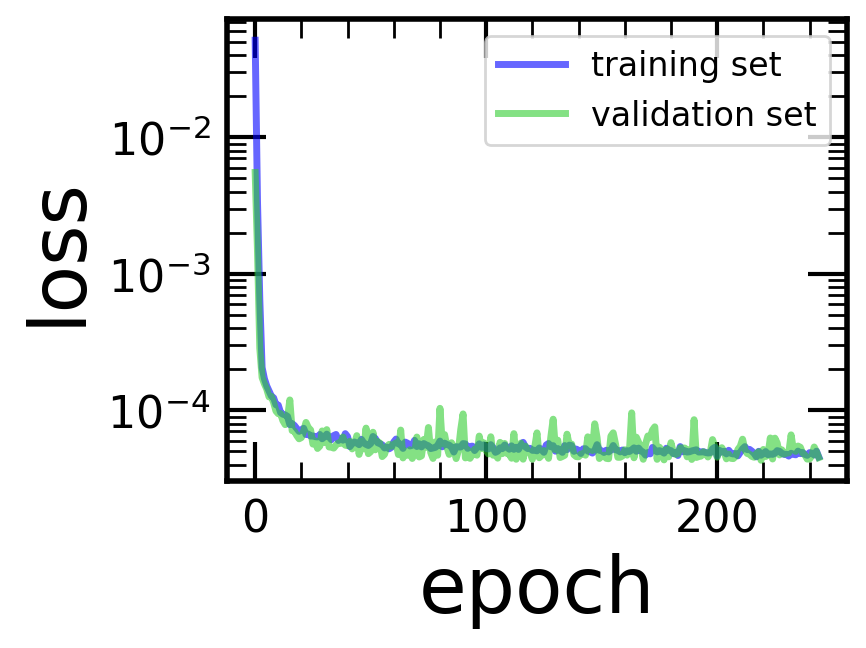

In [53]:
plotter.plot_loss(history_mean)

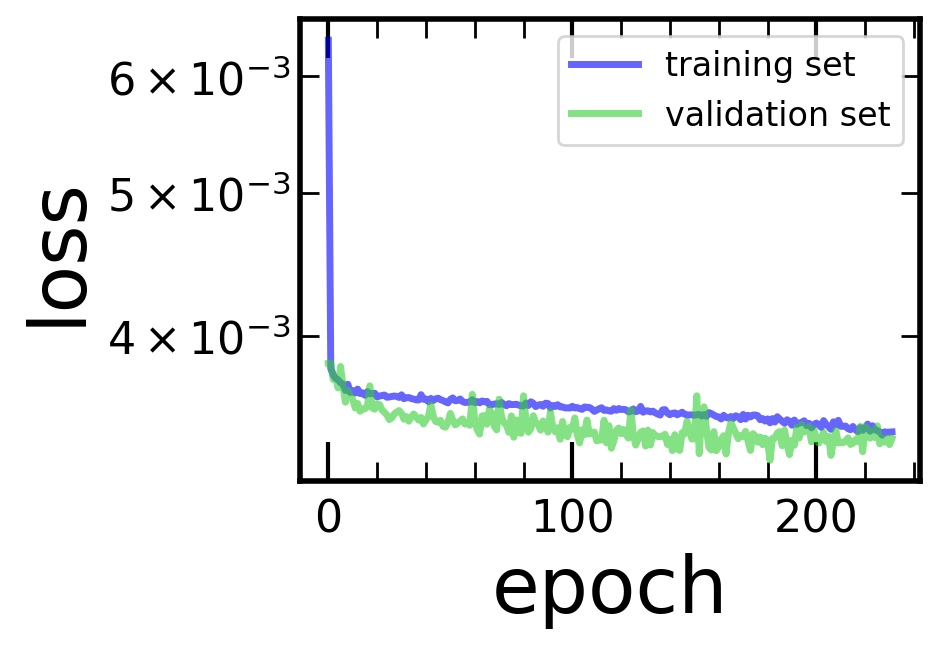

In [54]:
plotter.plot_loss(history_cov)

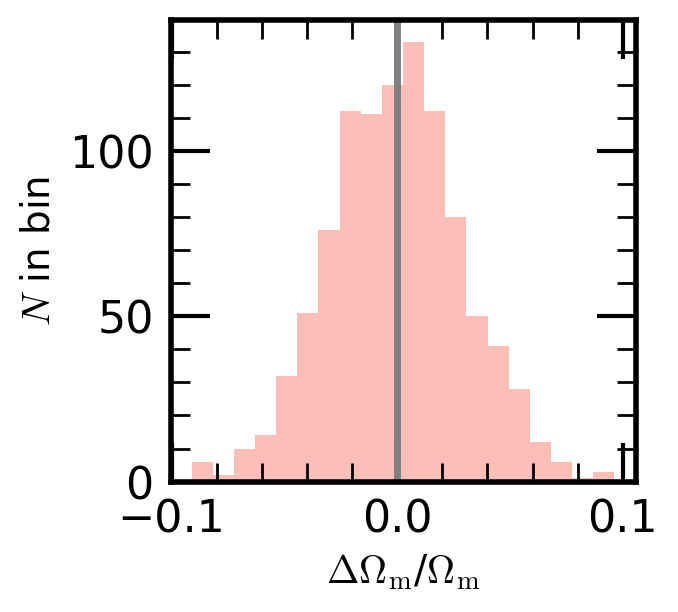

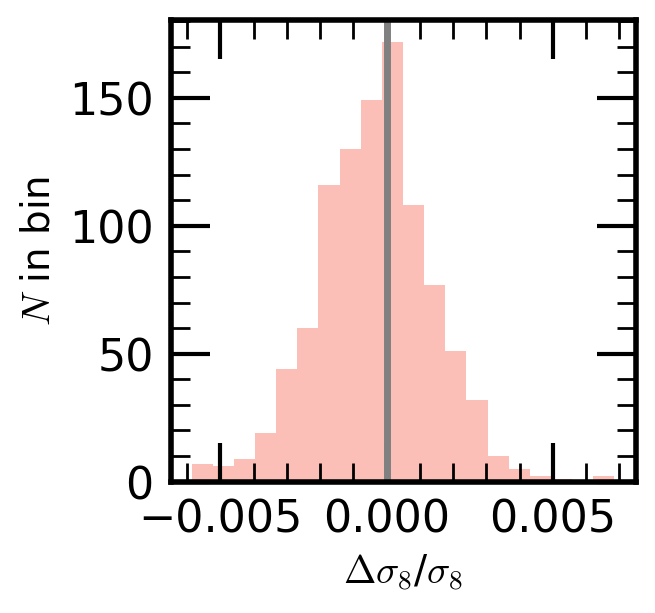

In [55]:

fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


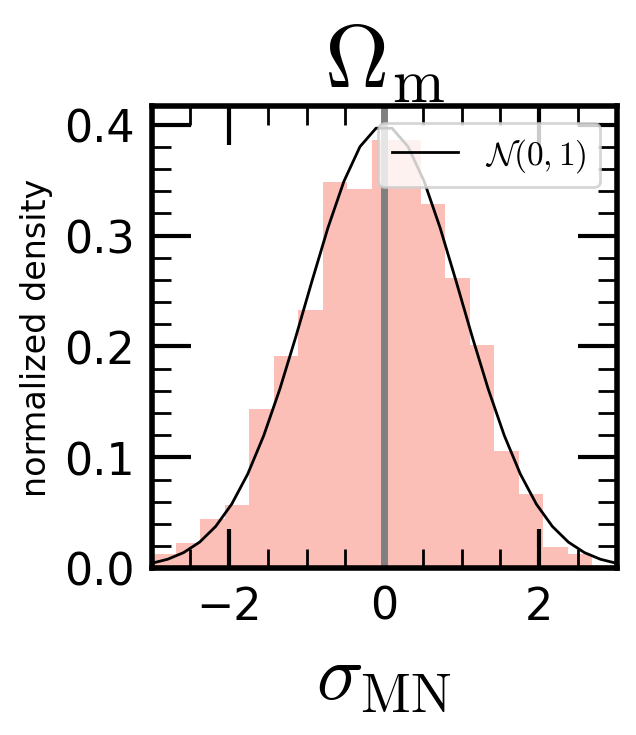

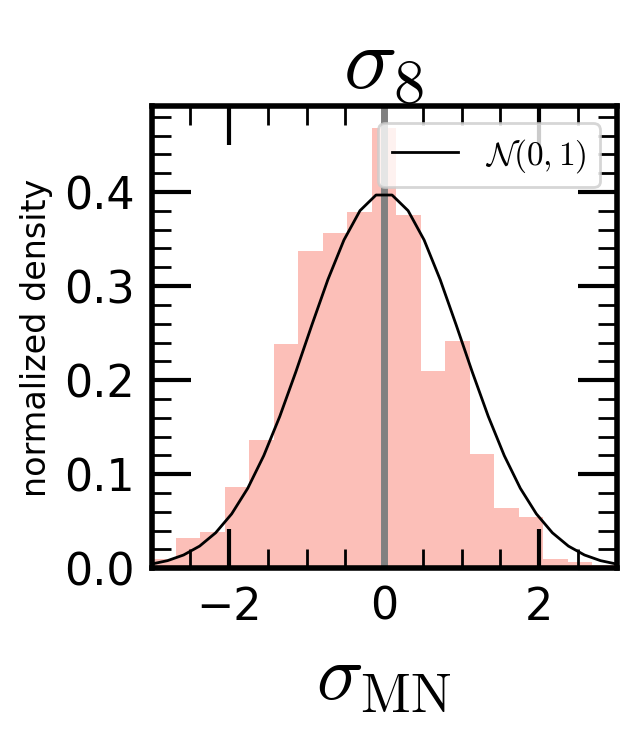

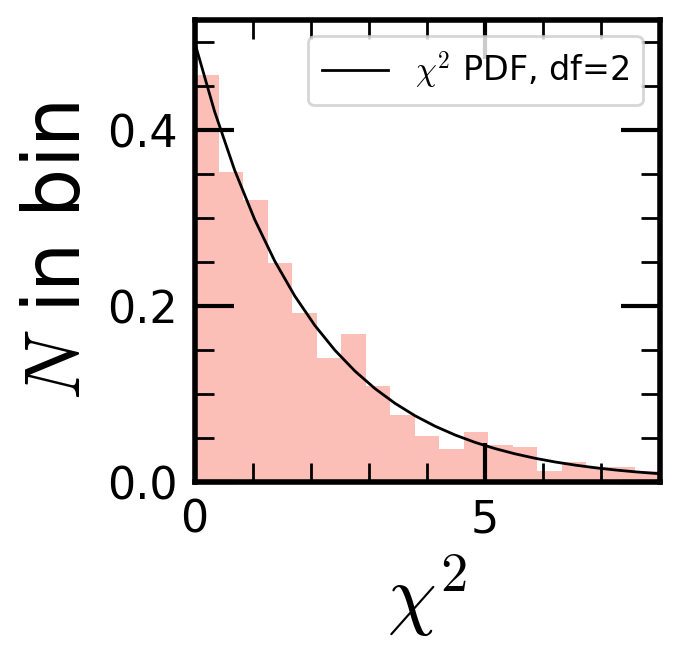

In [56]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

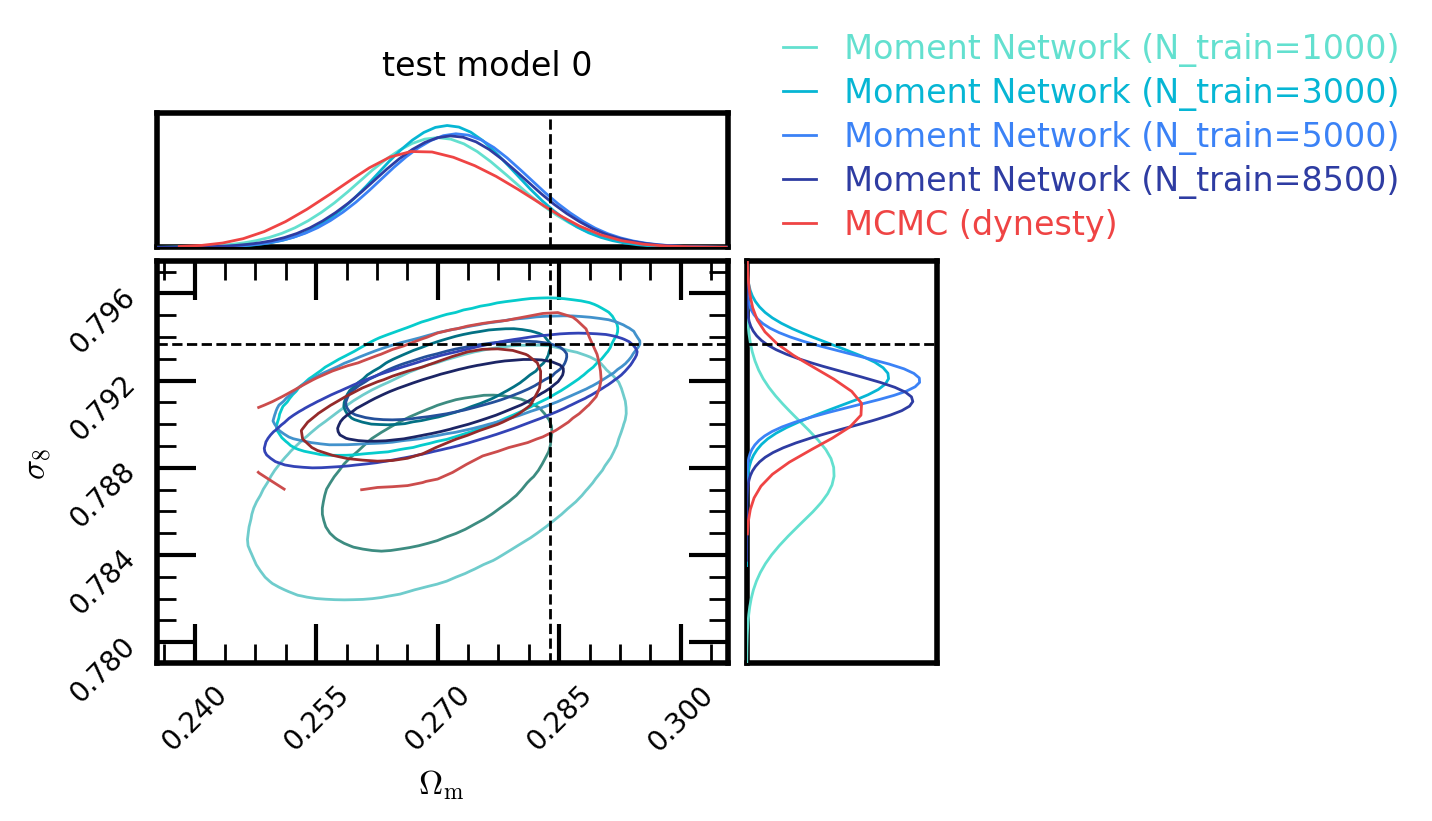

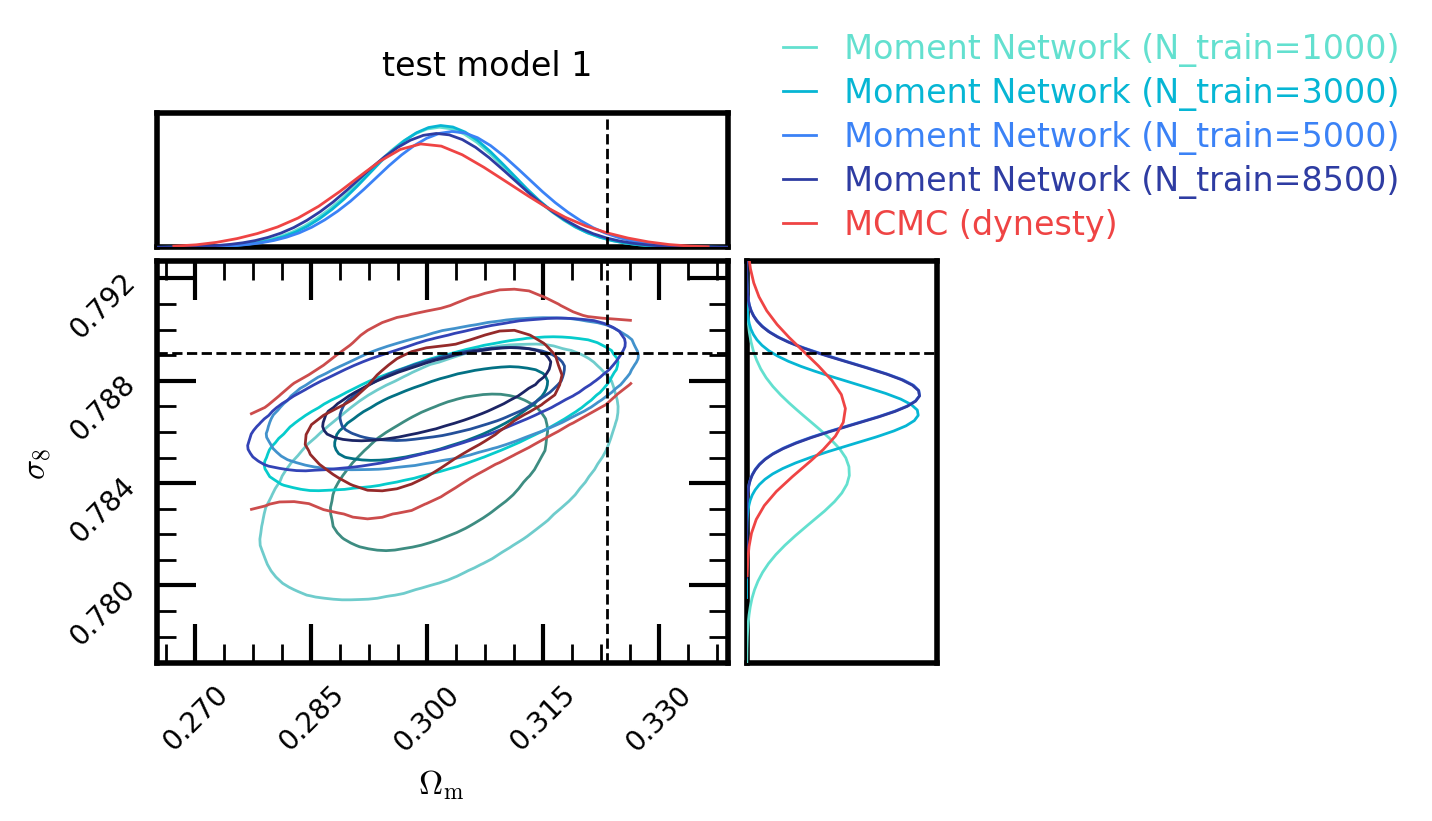

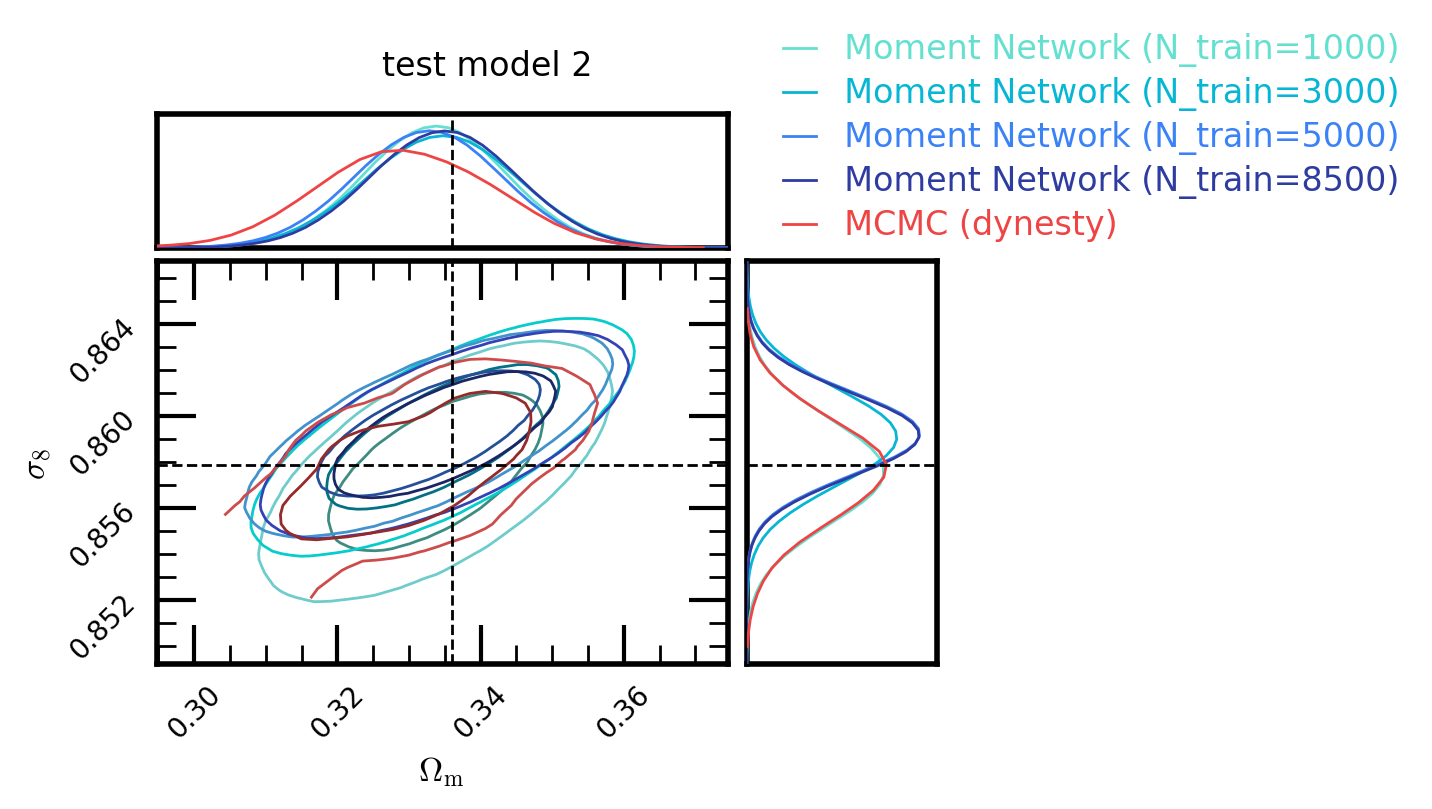

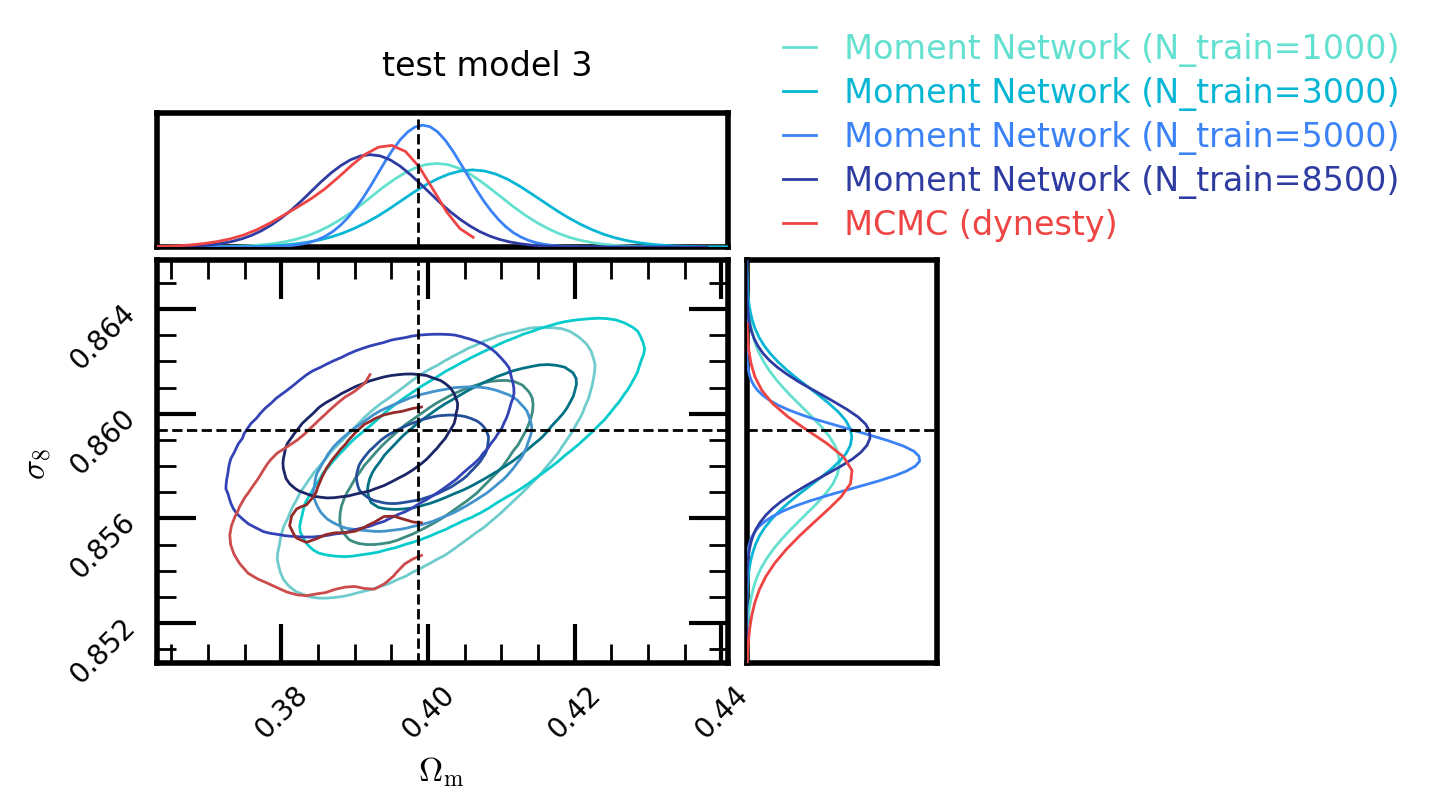

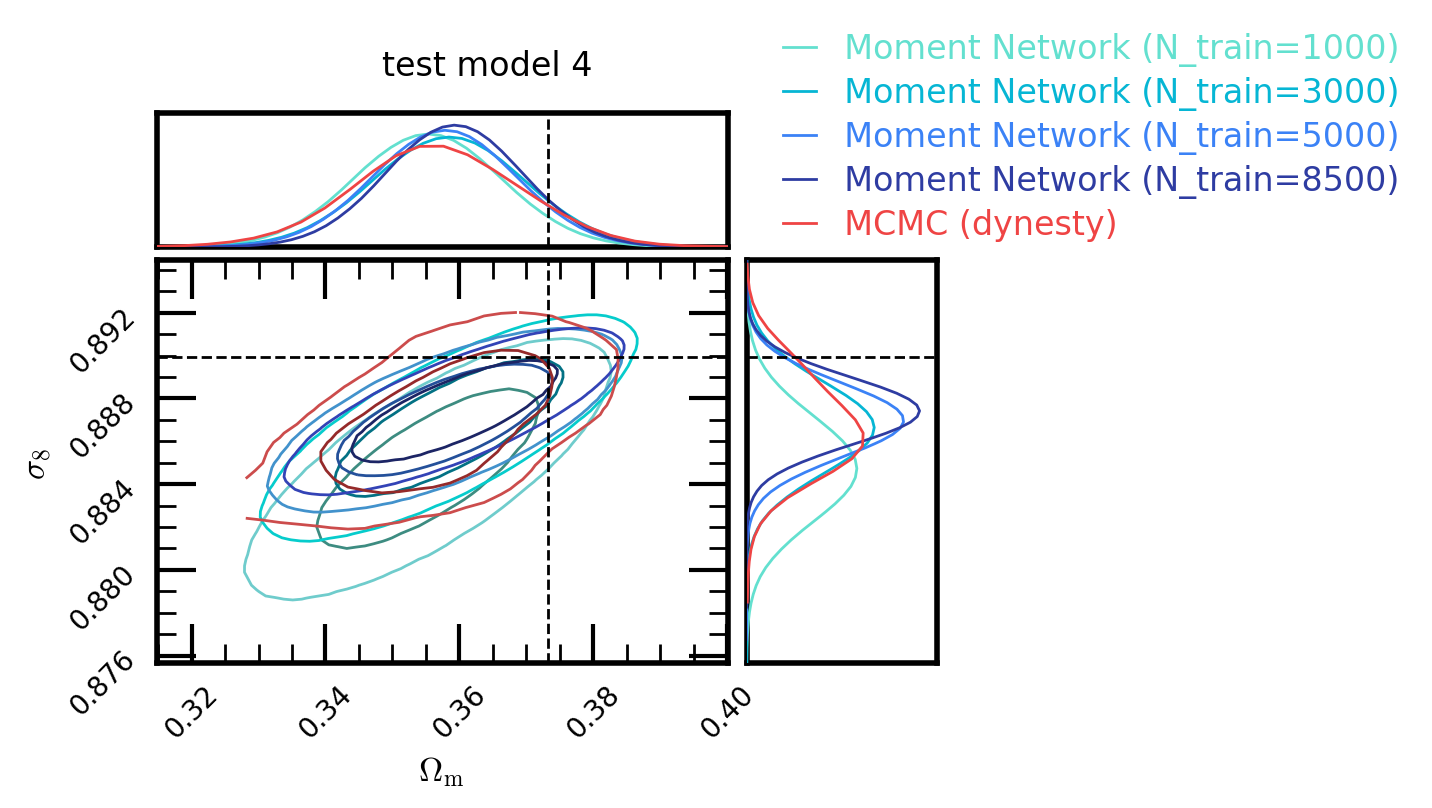

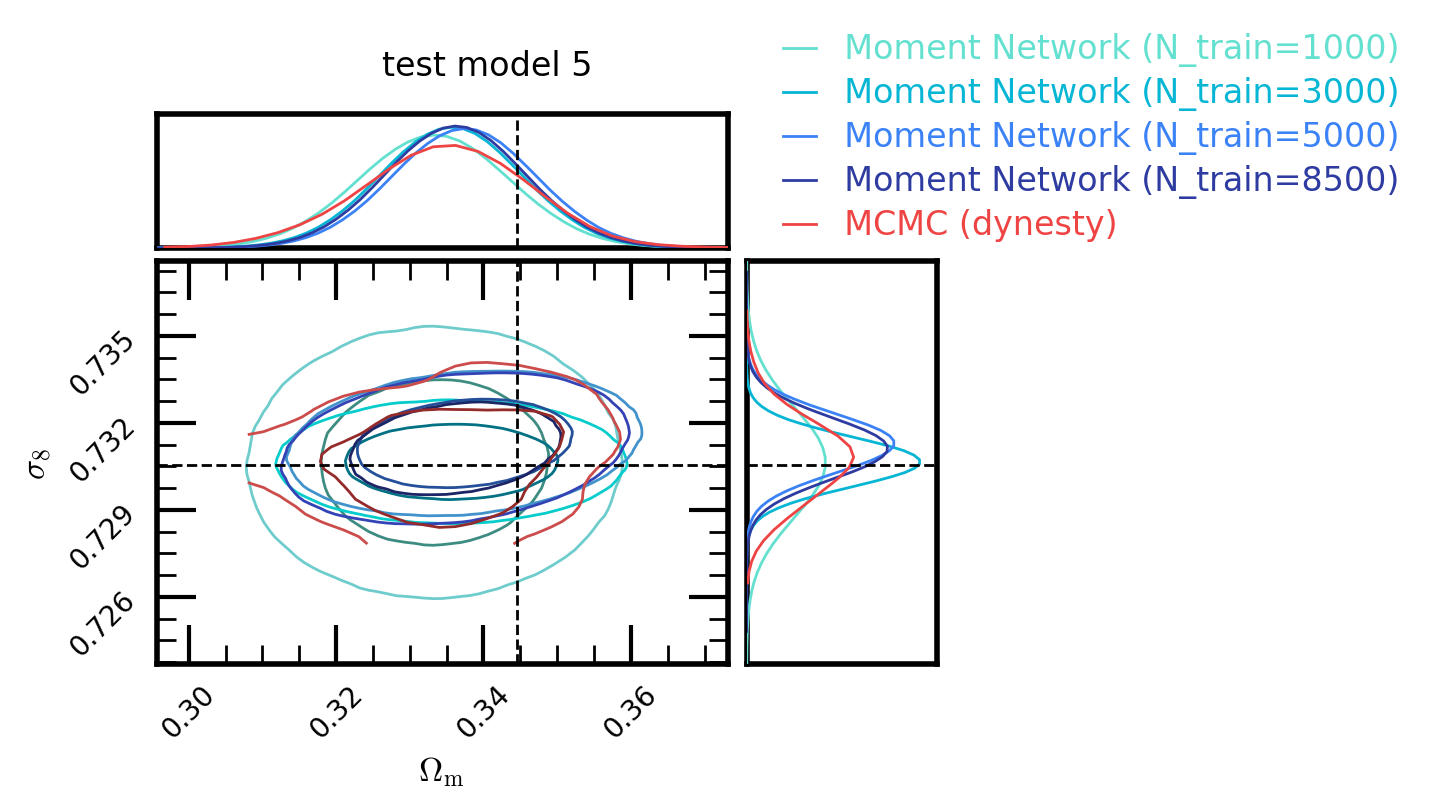

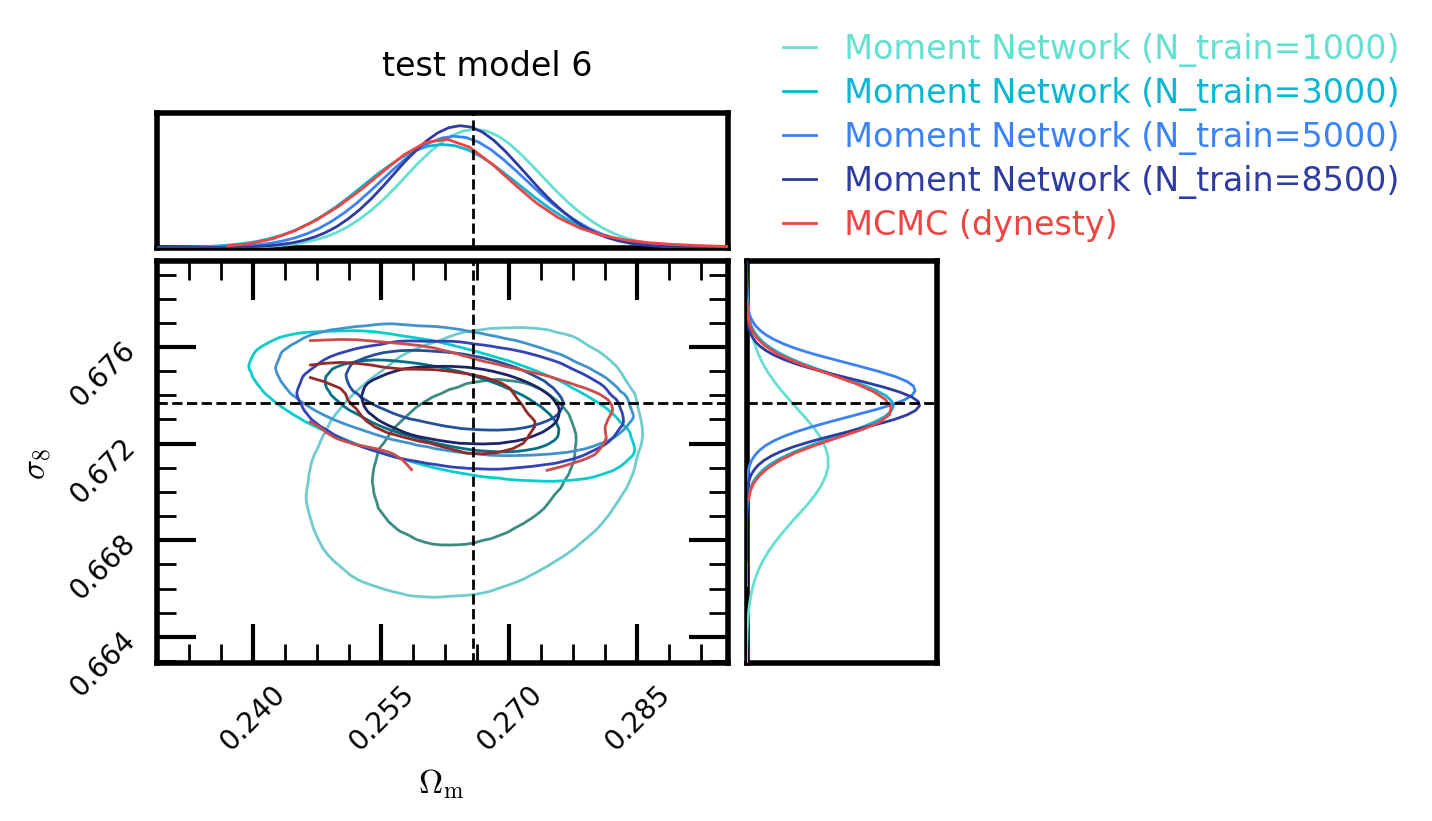

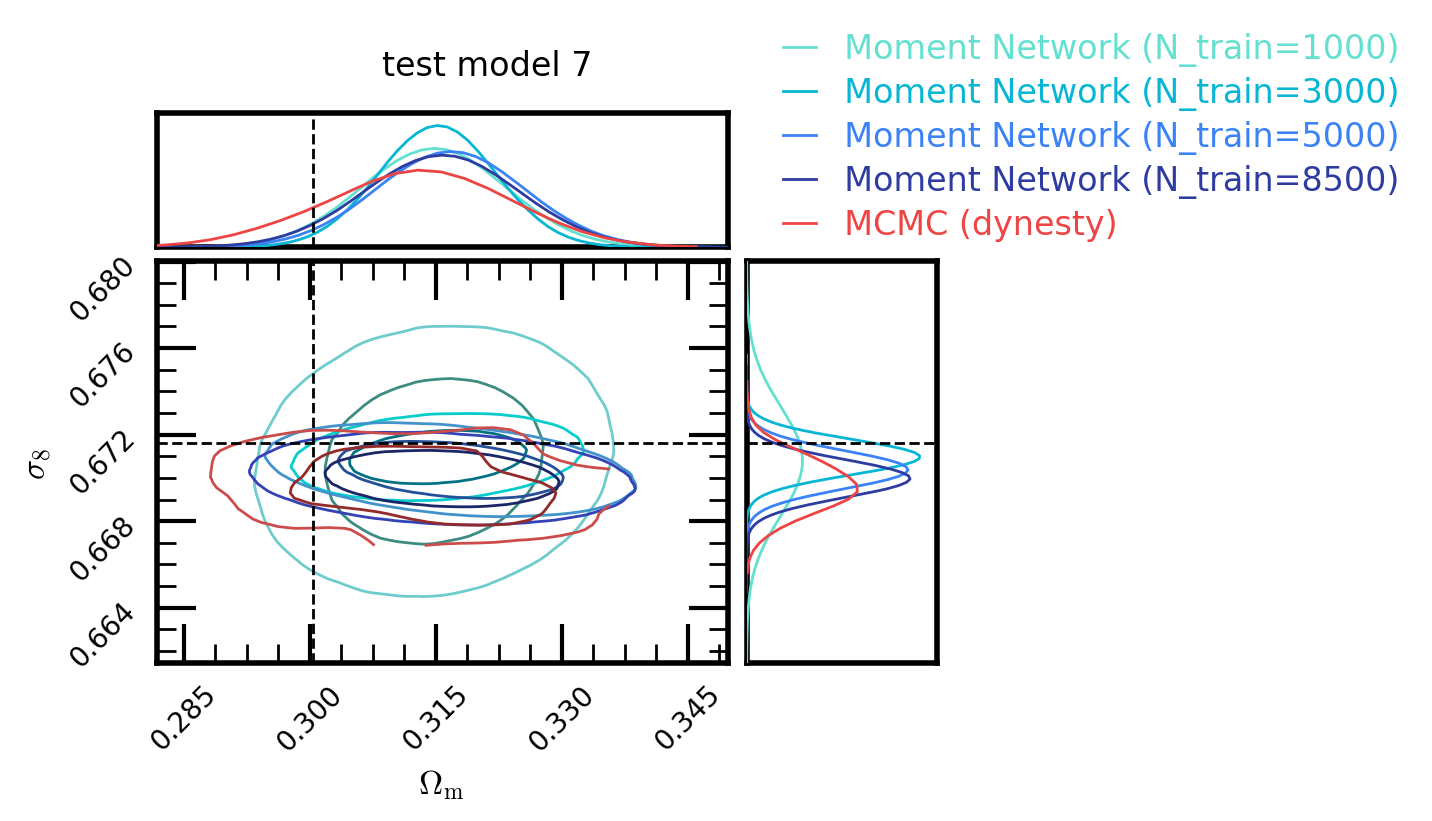

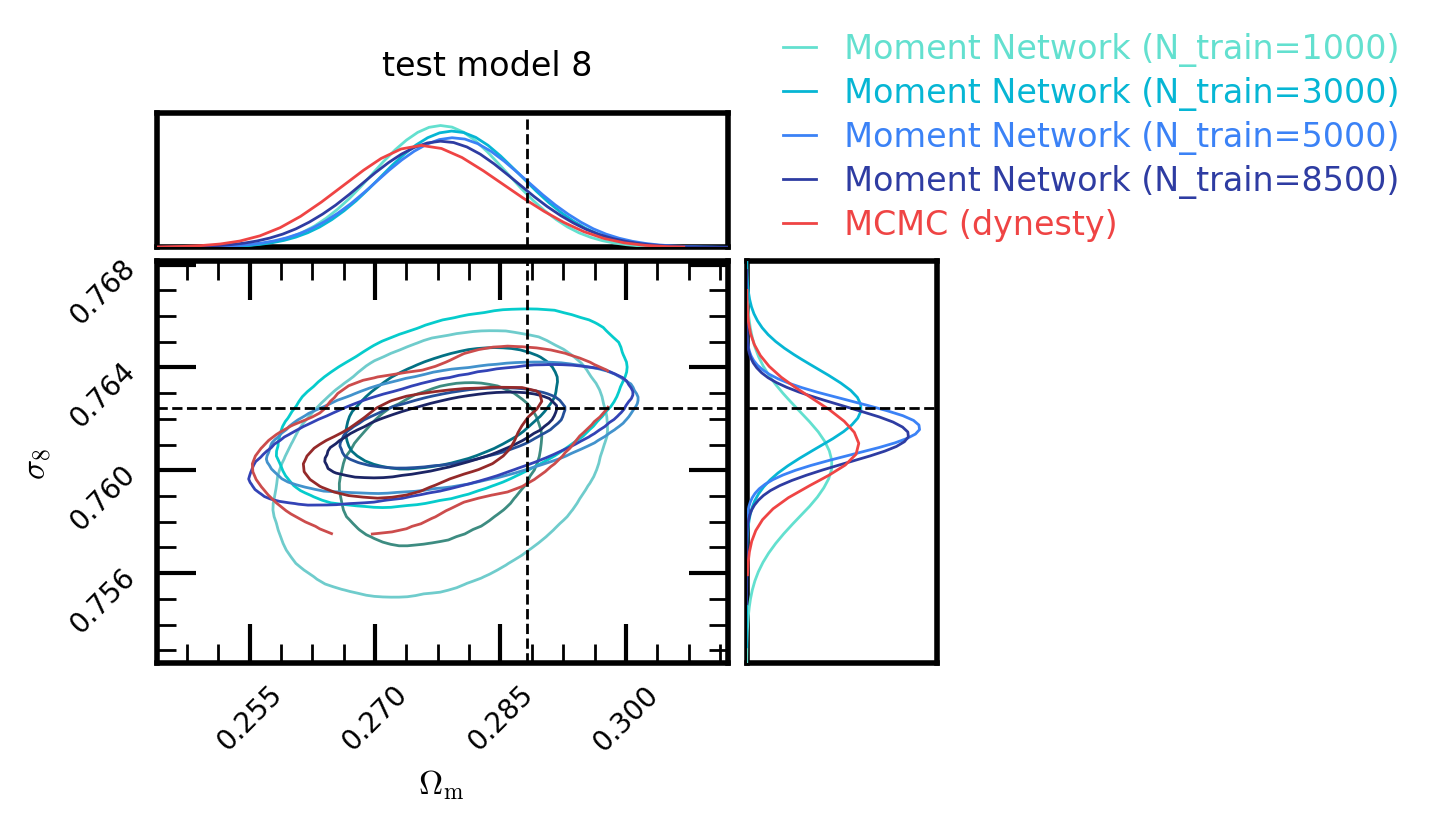

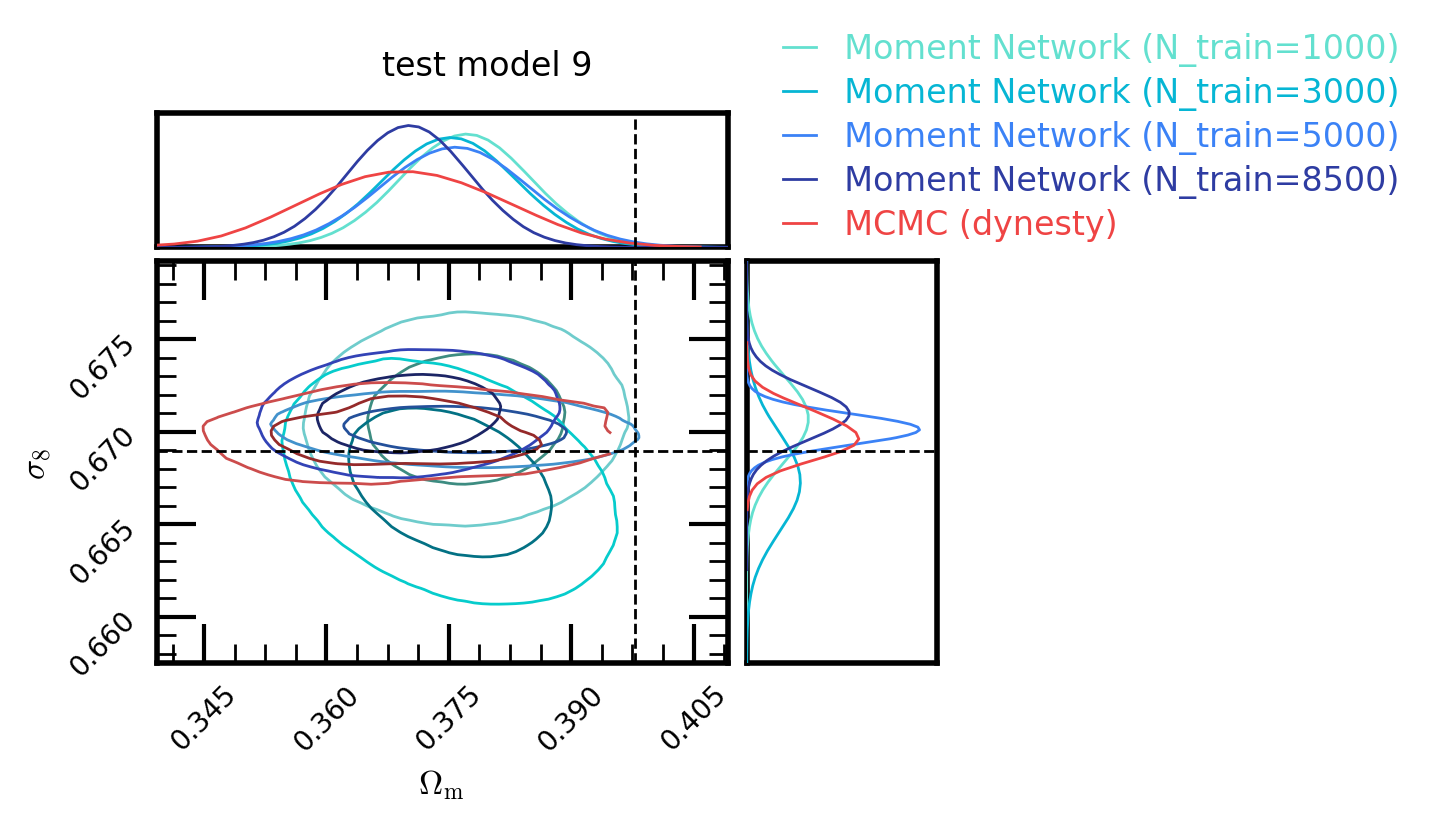

In [29]:
inf_methods = ['mn', 'mn', 'mn', 'mn', 'dynesty']
#tags_inf = [tag_inf]*len(methods)
tags_inf = ['_emuPk_2param_boxsize500_ntrain1000',
            '_emuPk_2param_boxsize500_ntrain3000',
            '_emuPk_2param_boxsize500_ntrain5000',
            '_emuPk_2param_boxsize500_ntrain8500',
            '_emuPk_2param_boxsize500']

labels_extra = ['(N_train=1000)', '(N_train=3000)', 
                '(N_train=5000)', '(N_train=8500)', '']
#colors = [utils.color_dict_methods[meth] for meth in methods]
colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']

for idx_obs in range(10):
    theta_obs_true = theta_test[idx_obs]
    plotter.plot_contours_inf(param_names, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, 
                            colors=colors, labels_extra=labels_extra)



In [37]:
import re
tag_inf_dynesty = tag_data
dir_dynesty =  f'../data/results_dynesty/samplers{tag_inf_dynesty}'
print(dir_dynesty)
idxs_testsub = []
pattern = r'idxtest(\d+)'
for fn in os.listdir(dir_dynesty):
    if "_idxtest" in fn:
        match = re.search(pattern, fn)
        idxs_testsub.append(int(match.group(1)))
print(len(idxs_testsub))

../data/results_dynesty/samplers_emuPk_2param_boxsize500
69


(69, 2)
(69, 2)


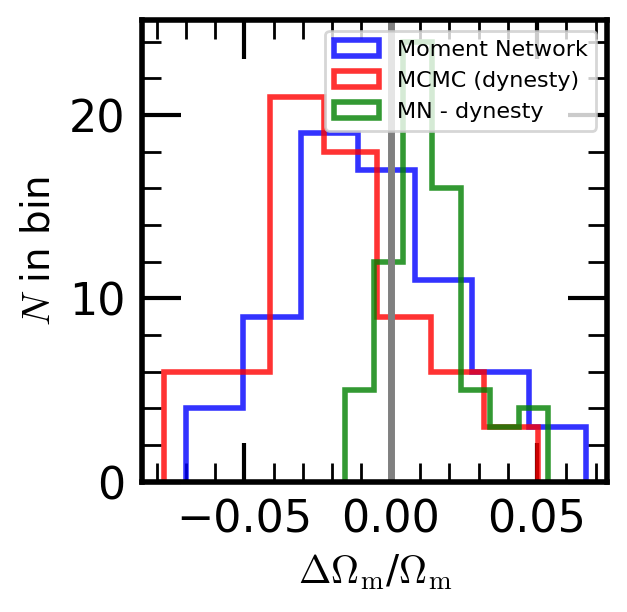

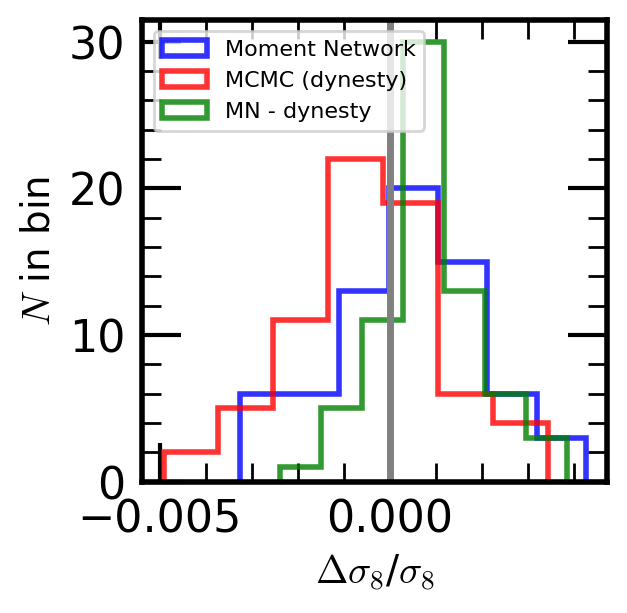

In [38]:

theta_testsub = theta_test[idxs_testsub]
theta_testsub_pred_mn = theta_test_pred[idxs_testsub]
theta_testsub_pred_dynesty = []
for idx_testsub in idxs_testsub:
    samples_dynesty = utils.get_samples_dynesty(idx_testsub, tag_inf_dynesty)
    theta_testsub_pred_dynesty.append( utils.get_posterior_maxes(samples_dynesty, param_names) )
    
theta_testsub_pred_dynesty = np.array(theta_testsub_pred_dynesty)
    

print(theta_testsub.shape)
print(theta_testsub_pred_dynesty.shape)
    
fracdiffs_mn = (theta_testsub_pred_mn - theta_testsub)/theta_testsub
#fracdiffs_emcee = (theta_testsub_pred_emcee - theta_testsub)/theta_testsub
fracdiffs_dynesty = (theta_testsub_pred_dynesty - theta_testsub)/theta_testsub
#fracdiffs_dynesty_emcee = (theta_testsub_pred_dynesty - theta_testsub_pred_emcee)/theta_testsub_pred_emcee
fracdiffs_mn_dynesty = (theta_testsub_pred_mn - theta_testsub_pred_dynesty)/theta_testsub_pred_dynesty

fracdiffs_arr = np.array([fracdiffs_mn, fracdiffs_dynesty, 
                          fracdiffs_mn_dynesty])
color_arr = [utils.color_dict_methods['mn'], 
             utils.color_dict_methods['dynesty'], 'green']
label_arr = [utils.label_dict_methods['mn'],
             utils.label_dict_methods['dynesty'], 'MN - dynesty']
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=color_arr, label_arr=label_arr,
                        bins=7, alpha=0.8, histtype='step')


In [40]:
print("hi")

hi


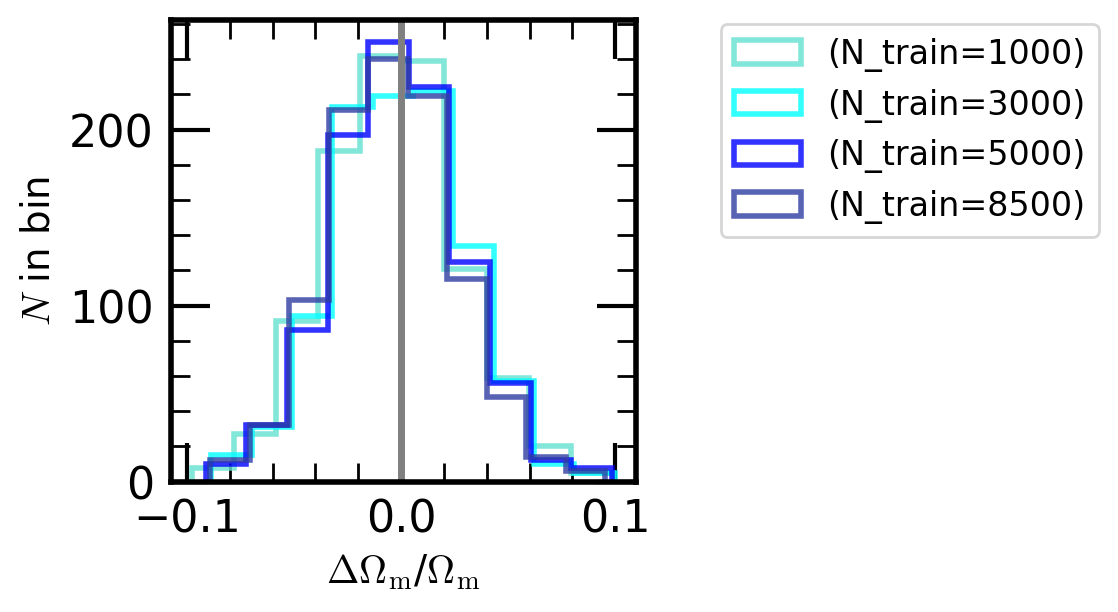

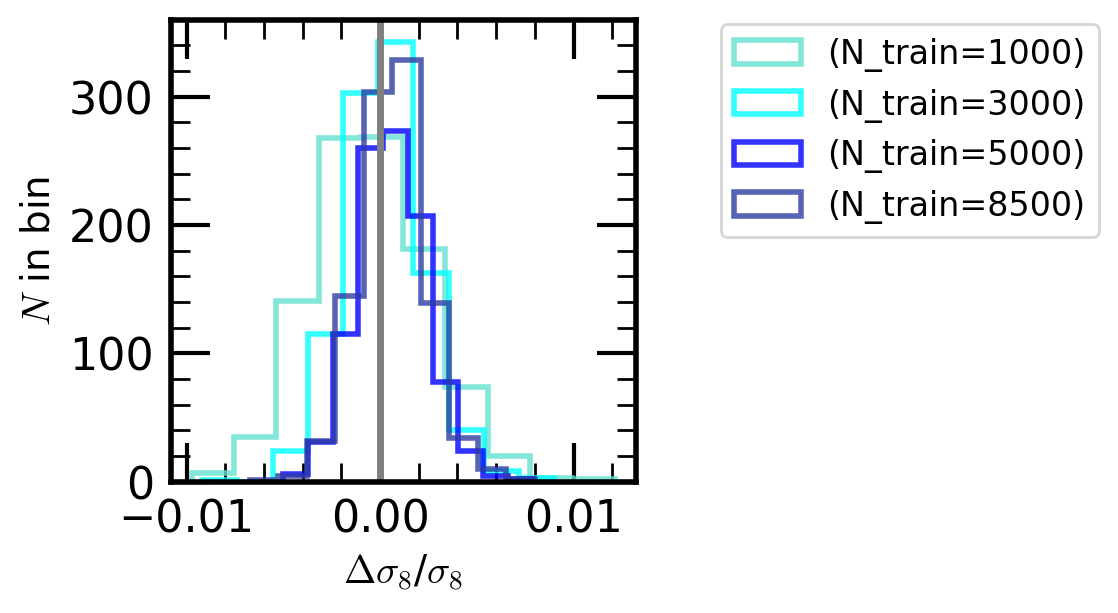

In [48]:
tags_inf = ['_emuPk_2param_boxsize500_ntrain1000',
            '_emuPk_2param_boxsize500_ntrain3000',
            '_emuPk_2param_boxsize500_ntrain5000',
            '_emuPk_2param_boxsize500_ntrain8500',
            ]

labels_extra = ['(N_train=1000)', '(N_train=3000)', 
                '(N_train=5000)', '(N_train=8500)', '']
#colors = [utils.color_dict_methods[meth] for meth in methods]
colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']

fracdiffs_arr = []
for tag_inf in tags_inf:
    _theta_test_pred, _  = utils.get_moments_test_mn(tag_inf)
    fracdiffs_mn = (_theta_test_pred - theta_test)/theta_test
    fracdiffs_arr.append(fracdiffs_mn)
fracdiffs_arr = np.array(fracdiffs_arr)

plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        bins=10, alpha=0.8, histtype='step')


### MCMC vs MN

In [65]:
idxs_obs = np.arange(100)
theta_obs = theta_test[idxs_obs]
theta_obs_pred_mn = theta_test_pred[idxs_obs]
covs_obs_pred_mn = covs_test_pred[idxs_obs]

covs_obs_pred_emcee = []
theta_obs_pred_emcee = []
for idx_obs in idxs_obs:
    samples_emcee = utils.get_samples_emcee(idx_obs, tag_data)
    theta_obs_pred_emcee.append( utils.get_posterior_maxes(samples_emcee, param_names) )
    covs_obs_pred_emcee.append( np.cov(samples_emcee.T) )
    
theta_obs_pred_emcee = np.array(theta_obs_pred_emcee)
covs_obs_pred_emcee = np.array(covs_obs_pred_emcee)

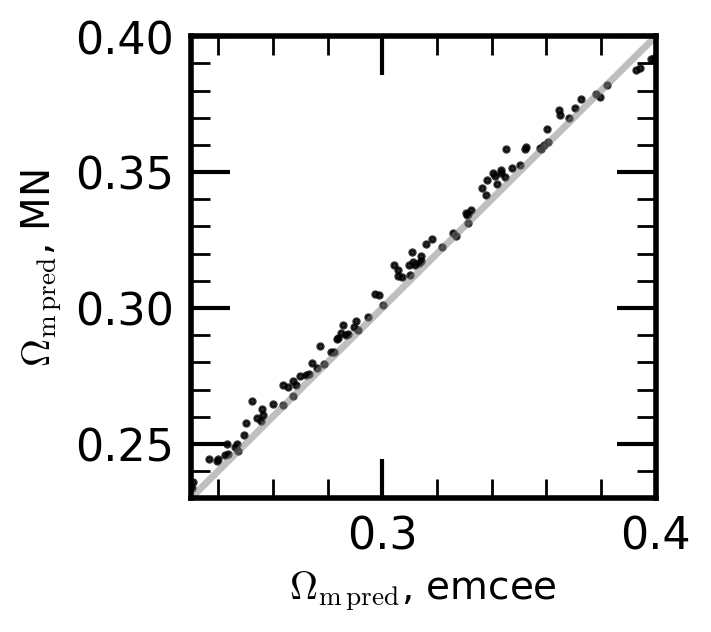

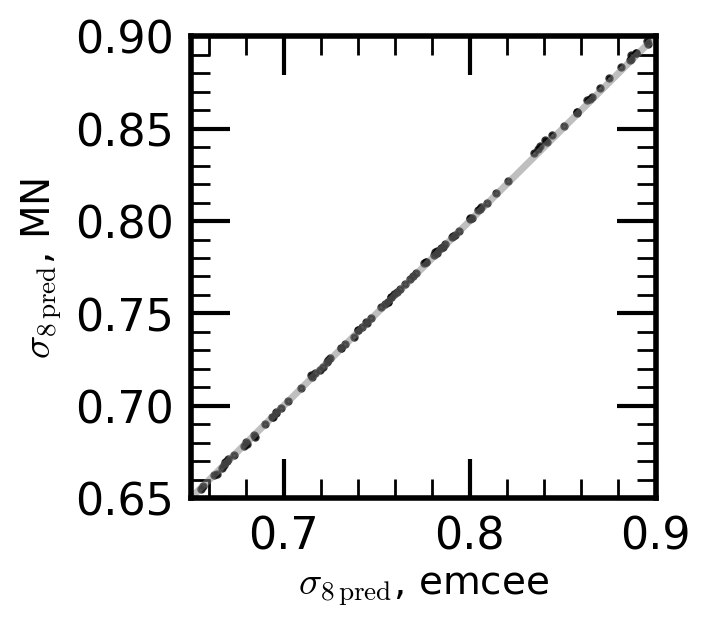

In [64]:
for pp, param_name in enumerate(param_names):
    plt.figure(figsize=(3,3))
    xx = np.linspace(*dict_bounds[param_name]) 
    plt.plot(xx, xx, color='grey', alpha=0.5)
    plt.scatter(theta_obs_pred_emcee[:,pp], theta_obs_pred_mn[:,pp],
                color='k', alpha=0.8, s=4)
    plt.xlabel(rf'{param_labels[pp]}$_\text{{pred}}$, emcee', fontsize=14)
    plt.ylabel(rf'{param_labels[pp]}$_\text{{pred}}$, MN', fontsize=14)
    plt.xlim(*dict_bounds[param_name])
    plt.ylim(*dict_bounds[param_name])


In [69]:
covs_obs_pred_emcee.shape

(100, 2, 2)

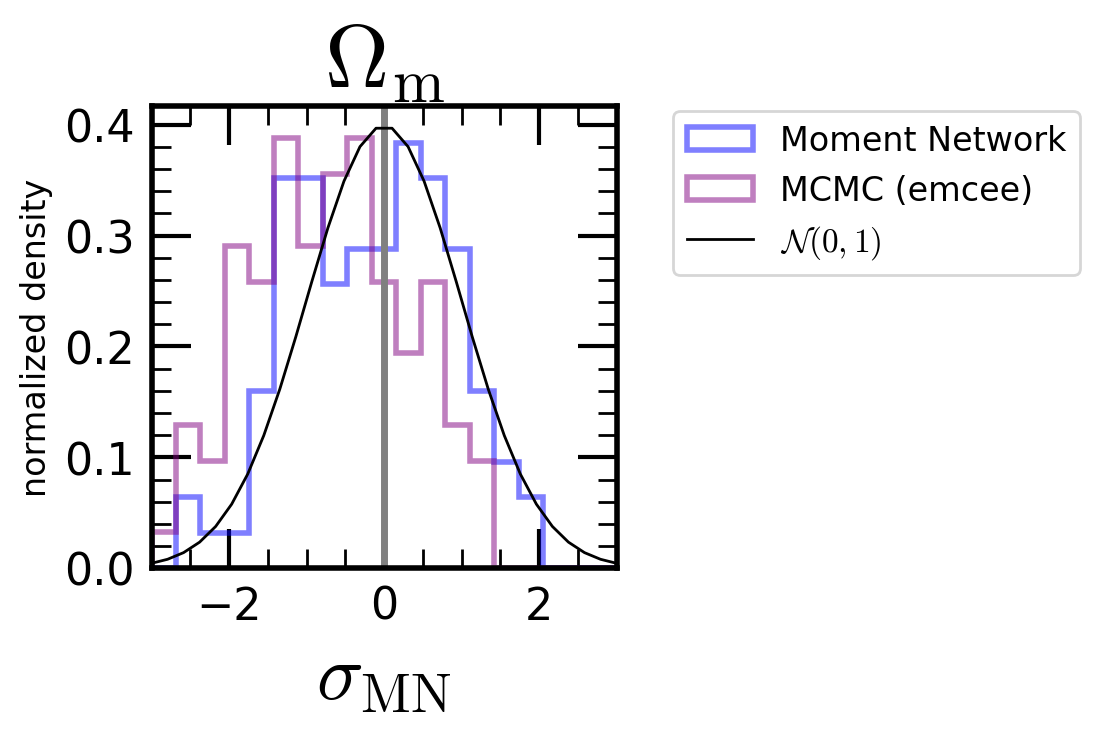

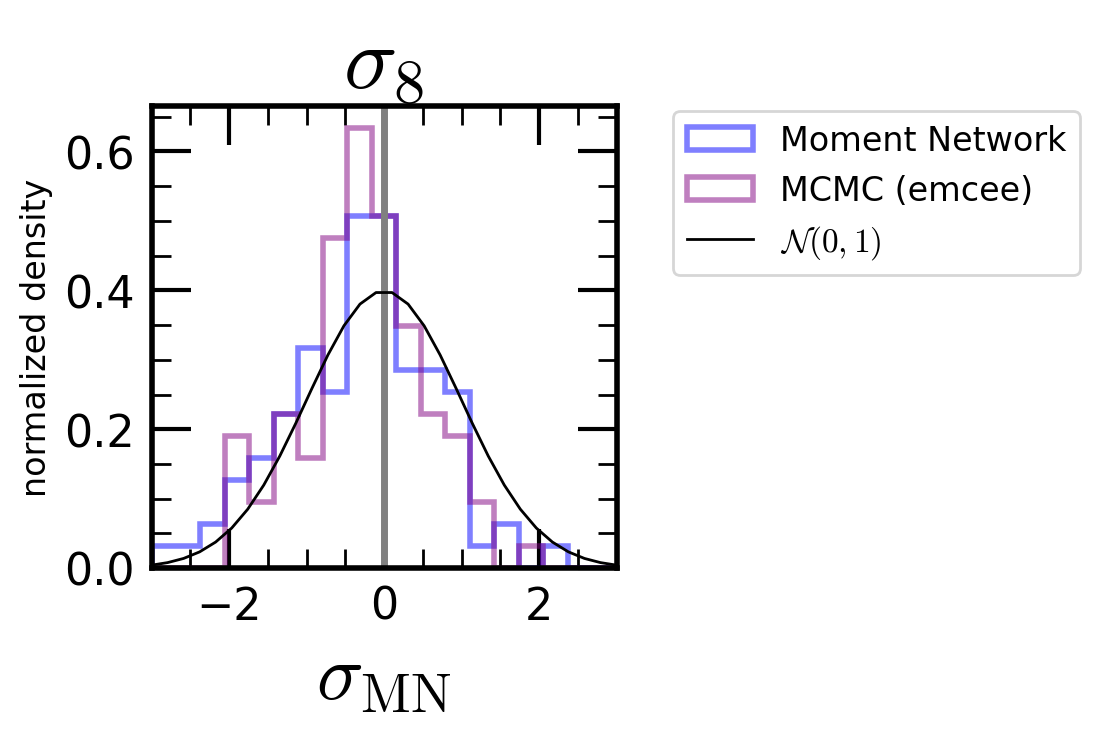

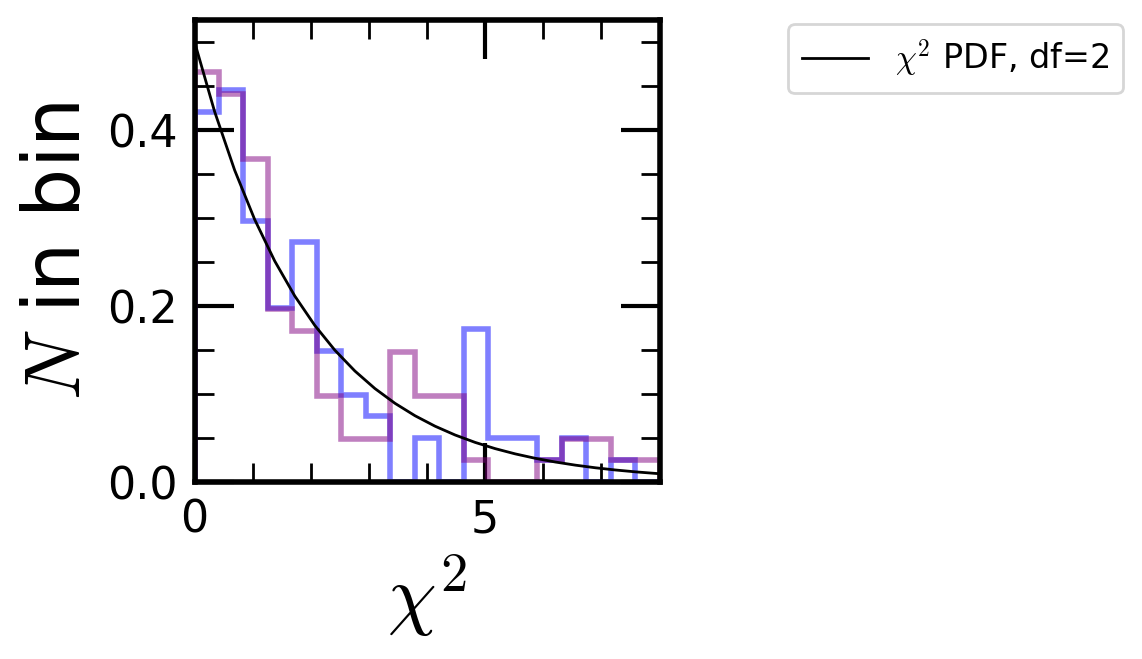

In [78]:
theta_obs_pred_arr = np.array([theta_obs_pred_mn, theta_obs_pred_emcee])
theta_obs_arr = np.array([theta_obs, theta_obs])
cov_obs_arr = np.array([covs_obs_pred_mn, covs_obs_pred_emcee])
color_arr = [utils.color_dict_methods['mn'], 
             utils.color_dict_methods['emcee']]
label_arr = [utils.label_dict_methods['mn'],
             utils.label_dict_methods['emcee']]
plotter.plot_hists_cov(theta_obs_arr, theta_obs_pred_arr, cov_obs_arr, param_labels,
                       color_arr=color_arr, label_arr=label_arr, histtype='step')
#plotter.plot_hists_cov(theta_obs, theta_obs_pred_emcee, covs_obs_pred_emcee, param_labels)

### Skewness

In [12]:
idx_obs = 2
tag_inf = tag_data
samples = utils.get_samples_emcee(idx_obs, tag_inf)

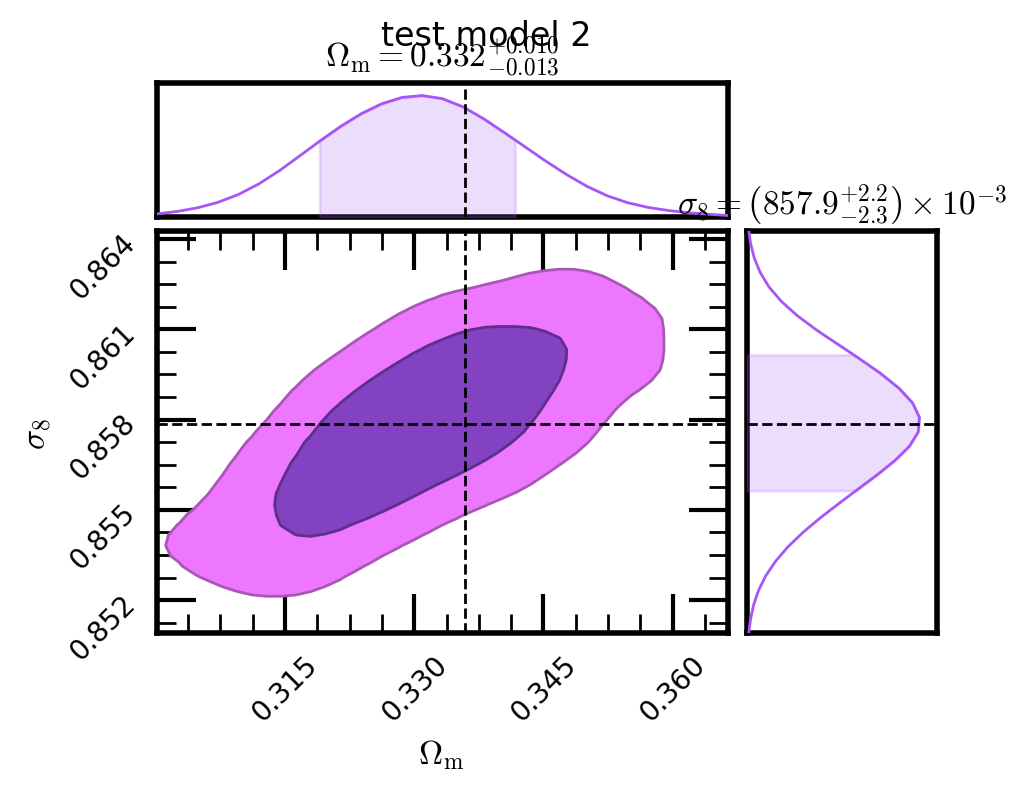

In [19]:
inf_methods = ['emcee']
tags_inf = [tag_inf]
theta_obs_true = theta_test[idx_obs]
plotter.plot_contours_inf(param_names, idx_obs, theta_obs_true, 
                        inf_methods, tags_inf 
                        #colors=colors, labels_extra=labels_extra
                        )



Cov about agrees w plot!

In [22]:
cov = np.cov(samples.T)
print(cov)
print(np.sqrt(np.diag(cov)))

[[1.14507328e-04 1.69978045e-05]
 [1.69978045e-05 4.41693479e-06]]
[0.01070081 0.00210165]


In [36]:
idxs_obs = np.arange(100)
tag_inf = tag_data
skews = []
skewtests = []
for idx_obs in idxs_obs:
    samples = utils.get_samples_emcee(idx_obs, tag_inf)
    skews.append( scipy.stats.skew(samples) ) 
    skewtests.append( scipy.stats.skewtest(samples) )
skews = np.array(skews)
pvals = np.array([s.pvalue for s in skewtests])


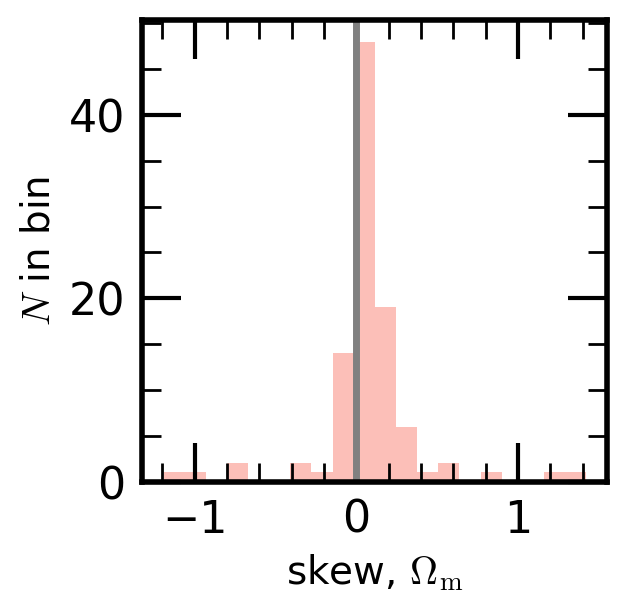

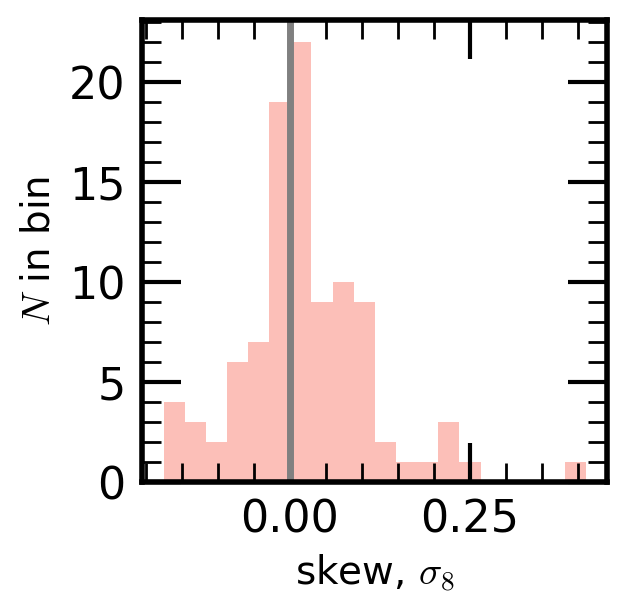

In [40]:
plotter.plot_hists_params(skews, param_labels, xlabel_base='skew')

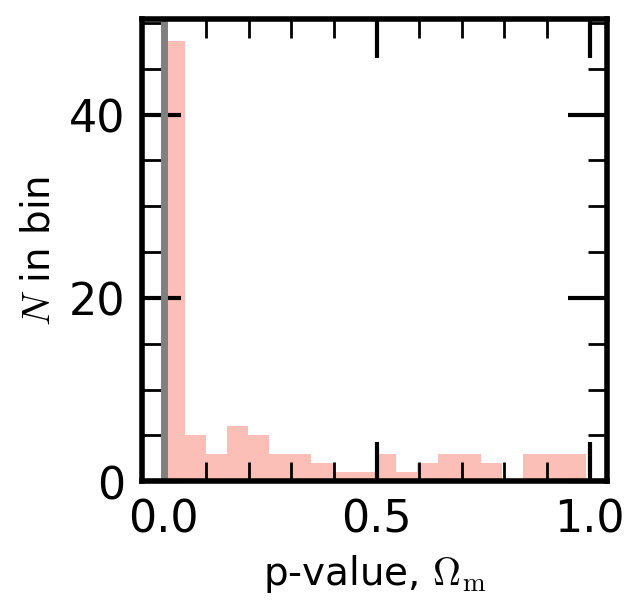

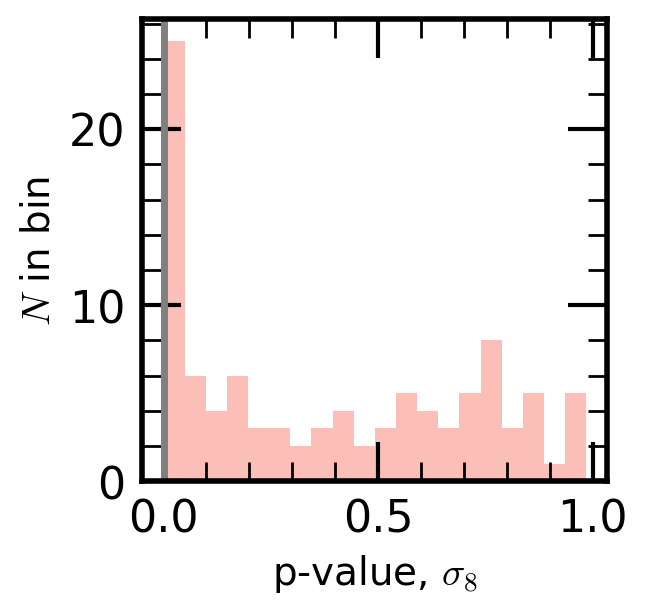

In [42]:
plotter.plot_hists_params(pvals, param_labels, xlabel_base='p-value')